## if you want to see more details in grid search, you need to replace some parameters.Otherwise, just run all the code and 2 prediction file will be created.

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier

# optimize parameters
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import BaggingClassifier

# 1. Loading & Spliting

In [2]:
#read csv file
text_train = pd.read_csv("review_text_train.csv")
meta_train = pd.read_csv("review_meta_train.csv")
labels = meta_train.rating

In [3]:
#load data
sparse_train_raw = sparse.load_npz('review_text_features_countvec/review_text_train_vec.npz')
sparse_test_raw = sparse.load_npz('review_text_features_countvec/review_text_test_vec.npz')
doc2vec_50 = pd.read_csv(r"review_text_features_doc2vec50/review_text_train_doc2vec50.csv", index_col = False, delimiter = ',', header=None)
doc2vec_100 = pd.read_csv(r"review_text_features_doc2vec100/review_text_train_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
doc2vec_200 = pd.read_csv(r"review_text_features_doc2vec200/review_text_train_doc2vec200.csv", index_col = False, delimiter = ',', header=None)

In [4]:
# train and test split
# split training data into training sets and validation sets
sparse_train, sparse_val, sparse_label_train, sparse_label_val = train_test_split(sparse_train_raw,labels,test_size=0.3,random_state=17)

d2v_50_train, d2v_50_val, d2v_50_label_train, d2v_50_label_val = train_test_split(doc2vec_50,labels,test_size=0.3,random_state=17)
d2v_100_train, d2v_100_val, d2v_100_label_train, d2v_100_label_val = train_test_split(doc2vec_100,labels,test_size=0.3,random_state=17)
d2v_200_train, d2v_200_val, d2v_200_label_train, d2v_200_label_val = train_test_split(doc2vec_200,labels,test_size=0.3,random_state=17)

# 2. Baseline model

### 2.1 One-R model 

In [5]:
one_r = DecisionTreeClassifier(max_depth=1)
one_r.fit(sparse_train, sparse_label_train)
one_r_acc = one_r.score(sparse_val, sparse_label_val)
print("Accuarcy of 0-R:",one_r_acc)

Accuarcy of 0-R: 0.7007481296758105


### 2.2 Naive Bayse

use simple model to understand the datasets

In [6]:
#  MultinomialNB performance on sparse matrix
MNB_sp =  MultinomialNB().fit(sparse_train, sparse_label_train)
print("Train accuracy:", MNB_sp.score(sparse_train, sparse_label_train))
print("validation accuracy", MNB_sp.score(sparse_val, sparse_label_val))

Train accuracy: 0.902427851580394
validation accuracy 0.8375489846811542


In [7]:
#  MultinomialNB performance on d2v matrix
MNB_d2v = GaussianNB().fit(d2v_50_train, d2v_50_label_train)
print("Train accuracy:", MNB_d2v.score(d2v_50_train, d2v_50_label_train))
print("validation accuracy",MNB_d2v.score(d2v_50_val, d2v_50_label_val))

Train accuracy: 0.7267776250827098
validation accuracy 0.7211732573328583


# 3. Model construction

## 3.1 Feature selection

In [8]:
# LinearSVC with default paramenters
sgd = SGDClassifier(loss='hinge', random_state=17)
sgd.fit(sparse_train, sparse_label_train)
print("Avg train accuracy:", cross_val_score(sgd, sparse_train, sparse_label_train, cv=5).mean())
print("validation accuracy:", sgd.score(sparse_val, sparse_label_val))

Avg train accuracy: 0.8228229055558037
validation accuracy: 0.8310176938605867


### Grid search

using the code of classification example in sklearn document:
<br>
'https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py'


In [9]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

#############################################################################
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('kbest',SelectKBest()),
    ('sgd', SGDClassifier(random_state=17)),
])

# Define the parameters that we want to tune
parameters = {
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__sublinear_tf': (True, False),
    'kbest__score_func':(chi2,f_classif),
    'kbest__k': (1000,5000,10000,20000,'all'),
    'sgd__penalty': ('l2', 'elasticnet'),
    'sgd__loss': ('hinge','log'),
}

# multiprocessing requires the fork to happen in a __main__ protected  block
if __name__ == "__main__":
    # find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(sparse_train, sparse_label_train)
    print("done in %0.3fs" % (time() - t0))
    print() 
    print("Best score: %0.4f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

pipeline: ['tfidf', 'kbest', 'sgd']
parameters:
{'kbest__k': (1000, 5000, 10000, 20000, 'all'),
 'kbest__score_func': (<function chi2 at 0x1a17c79ea0>,
                       <function f_classif at 0x1a17c79d90>),
 'sgd__loss': ('hinge', 'log'),
 'sgd__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__sublinear_tf': (True, False)}
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.7min finished


done in 101.072s

Best score: 0.8457
Best parameters set:
	kbest__k: 'all'
	kbest__score_func: <function chi2 at 0x1a17c79ea0>
	sgd__loss: 'hinge'
	sgd__penalty: 'l2'
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True


In [10]:
# show top 5 optimal parameter sets
opt_sets = grid_search.cv_results_ 
rank_score = opt_sets['rank_test_score']
rank_sets = sorted(range(len(rank_score)), key=rank_score.__getitem__)
for i in rank_sets[:3]:
    print("parameter set:", opt_sets['params'][i])
    print("Accuracy:", opt_sets['mean_test_score'][i])
    print()    

parameter set: {'kbest__k': 'all', 'kbest__score_func': <function chi2 at 0x1a17c79ea0>, 'sgd__loss': 'hinge', 'sgd__penalty': 'l2', 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}
Accuracy: 0.8457270830152186

parameter set: {'kbest__k': 'all', 'kbest__score_func': <function f_classif at 0x1a17c79d90>, 'sgd__loss': 'hinge', 'sgd__penalty': 'l2', 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}
Accuracy: 0.8457270830152186

parameter set: {'kbest__k': 20000, 'kbest__score_func': <function chi2 at 0x1a17c79ea0>, 'sgd__loss': 'hinge', 'sgd__penalty': 'l2', 'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}
Accuracy: 0.8455234895912862



### Compare the accuracy

In [11]:
 # fit model
tfidf_opt = TfidfTransformer(norm='l2', sublinear_tf=True).fit(sparse_train)
train_opt = tfidf_opt.transform(sparse_train)
val_opt = tfidf_opt.transform(sparse_val)
test_opt = tfidf_opt.transform(sparse_test_raw)

* optimal parameter sets

In [12]:
sgd_opt = SGDClassifier(loss='hinge', penalty="l2", random_state=17).fit(train_opt, sparse_label_train)
print("Avg train accuracy:", cross_val_score(sgd_opt, train_opt, sparse_label_train, cv=5).mean())
print("validation accuracy:", sgd_opt.score(val_opt, sparse_label_val))

Avg train accuracy: 0.8457270106735522
validation accuracy: 0.8497803111269445


* Compare the performance with the parameter sets which remove TF-IDF<br>
` to get the parameter sets, you need to run the grid search again and remove line 15,22,23`

In [13]:
kbest_wt = SelectKBest(f_classif, k=5000).fit(train_opt, sparse_label_train)
train_wt = kbest_wt.transform(sparse_train)
val_wt = kbest_wt.transform(sparse_val)
test_wt = kbest_wt.transform(sparse_test_raw)
sgd_wt = SGDClassifier(loss='log', penalty='elasticnet', random_state=17).fit(train_wt, sparse_label_train)

print("Avg train accuracy:", cross_val_score(sgd_wt, train_wt, sparse_label_train, cv=5).mean())
print("validation accuracy:", sgd_wt.score(val_wt, sparse_label_val))

/Users/yuanxinyi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/Users/yuanxinyi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Users/yuanxinyi/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Avg train accuracy: 0.8456252165505147
validation accuracy: 0.8437240232751455


* Compare the performance with the parameter sets which reduces the features to 20000

In [14]:
kbest = SelectKBest(chi2, k=20000).fit(train_opt, sparse_label_train)
train_k = kbest.transform(train_opt)
val_k = kbest.transform(val_opt)
test_k = kbest.transform(test_opt)
sgd_k = SGDClassifier(loss='hinge', penalty="l2", random_state=17).fit(train_k, sparse_label_train)

print("Avg train accuracy:", cross_val_score(sgd_k, train_k, sparse_label_train, cv=5).mean())
print("validation accuracy:", sgd_k.score(val_k, sparse_label_val))

Avg train accuracy: 0.8497479368200314
validation accuracy: 0.8487115544472152


## 3.2 tuning parameters

In [15]:
# show default SVC accuracy for comparison
svc = LinearSVC().fit(train_opt, sparse_label_train)
print("Avg train accuracy:", svc.score( train_opt, sparse_label_train))
print("validation accuracy:", svc.score(val_opt, sparse_label_val))

Avg train accuracy: 0.9772993332315366
validation accuracy: 0.8497803111269445


### Validation curve

Using validation curve to tune optimal C
<br>
<br>
To plot validation_curve, use the code from scikit-learn documentation:
<br>
"https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py"

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.1s finished


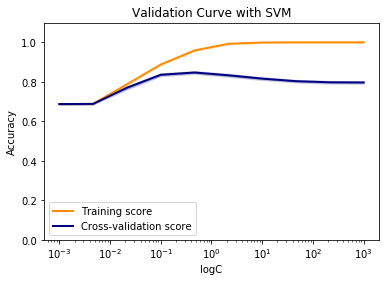

In [16]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
    LinearSVC(), train_opt, sparse_label_train, param_name="C", param_range=param_range,
    cv=5, verbose=1,n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("logC")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [17]:
# best C value
C_opt = param_range[test_scores_mean.argmax()]
print("best_C:",C_opt)
svc_opt = LinearSVC(C=C_opt).fit(train_opt,sparse_label_train)

print("train accuracy:", svc_opt.score(train_opt, sparse_label_train))
print("validation accuracy:", svc_opt.score(val_opt, sparse_label_val))
print()
# using cv to decrease variance
print("using 5-fold cross validation:")
print("Avg train accuracy:", cross_val_score(svc_opt, train_opt, sparse_label_train, cv=5).mean())
print("validation accuracy:", svc_opt.score(val_opt, sparse_label_val))

best_C: 0.46415888336127775
train accuracy: 0.9552094467348705
validation accuracy: 0.8554803467521672

using 5-fold cross validation:
Avg train accuracy: 0.847304800151804
validation accuracy: 0.8554803467521672


## visualize the evaluation

In [18]:
#evaluation table
svc_prediction = svc_opt.predict(val_opt)
print(classification_report(sparse_label_val, svc_prediction))

              precision    recall  f1-score   support

           1       0.80      0.67      0.73       714
           3       0.77      0.62      0.68      1929
           5       0.88      0.96      0.92      5778

    accuracy                           0.86      8421
   macro avg       0.82      0.75      0.78      8421
weighted avg       0.85      0.86      0.85      8421



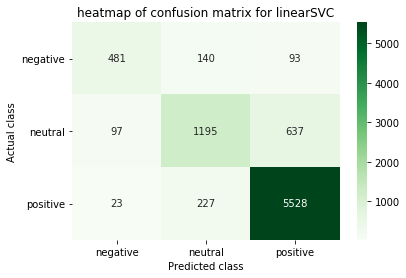

In [19]:
#heatmap
matric_svc = confusion_matrix(sparse_label_val, svc_prediction)
sns.heatmap(matric_svc, annot=True, fmt='d', 
            xticklabels=['negative','neutral','positive'],yticklabels=['negative','neutral','positive'], cmap='Greens')
plt.title('heatmap of confusion matrix for linearSVC')
plt.xlabel('Predicted class')
plt.yticks(rotation=360)
plt.ylabel('Actual class')
plt.show()

## 1.2 Adding the votes of reviews

In [20]:
votes = meta_train.loc[:,['vote_funny','vote_cool','vote_useful']]

In [21]:
#add users's votes into data
vote_train, vote_val = train_test_split(votes,test_size=0.3,random_state=17)
train_sparse_vote = sparse.hstack((train_opt, vote_train))
val_sparse_vote = sparse.hstack((val_opt, vote_val))

svc_vote = LinearSVC(C=C_opt).fit(train_sparse_vote,sparse_label_train)
print("Avg train accuracy:", cross_val_score(svc_vote, train_sparse_vote, sparse_label_train, cv=5).mean())
print("validation accuracy:", svc_vote.score(val_sparse_vote, sparse_label_val))

/Users/yuanxinyi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/yuanxinyi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Avg train accuracy: 0.84995147325589
validation accuracy: 0.8554803467521672


# 4. BaggingClassifier

In [22]:

t0 = time()
bagging = BaggingClassifier().fit(train_opt,sparse_label_train)
print("Avg train accuracy:", cross_val_score(bagging, train_opt, sparse_label_train, cv=5).mean())
print("validation accuracy:", bagging.score(val_opt, sparse_label_val))
print("done in %0.3fs" % (time() - t0))

Avg train accuracy: 0.7630166628132817
validation accuracy: 0.767129794561216
done in 422.898s


In [23]:
#change base_estimator
from time import time
t1 = time()
bagging = BaggingClassifier(base_estimator= SGDClassifier(loss='hinge', penalty="l2"),random_state=17).fit(train_opt,sparse_label_train)
print("Avg train accuracy:", cross_val_score(bagging, train_opt, sparse_label_train, cv=5).mean())
print("validation accuracy:", bagging.score(val_opt, sparse_label_val))
print("done in %0.3fs" % (time() - t1))


Avg train accuracy: 0.8451161682200017
validation accuracy: 0.8512053200332502
done in 9.435s


# 5. Testing

* Return prediction file to test data for linearSVC model

In [24]:
# use whole training data
tfidf_opt = TfidfTransformer(norm='l2', sublinear_tf=True).fit(sparse_train_raw)
train_opt = tfidf_opt.transform(sparse_train_raw)
test_opt = tfidf_opt.transform(sparse_test_raw)
C_opt = param_range[test_scores_mean.argmax()]
svc_opt = LinearSVC(C=C_opt).fit(train_opt,labels)
pred_result = svc_opt.predict(test_opt)
# return prediction csv file
test_data = pd.read_csv("review_text_test.csv")
output = pd.DataFrame()
output['Instance_id']= np.arange(1,len(test_data)+1)
output['rating'] = pred_result
output.to_csv('test_linearSVC.csv', index = False)

* Return prediction file to test data for bagging model

In [25]:
tfidf_opt = TfidfTransformer(norm='l2', sublinear_tf=True).fit(sparse_train_raw)
train_opt = tfidf_opt.transform(sparse_train_raw)
test_opt = tfidf_opt.transform(sparse_test_raw)
pred_result = bagging.predict(test_opt)
# return prediction csv file
test_data = pd.read_csv("review_text_test.csv")
output = pd.DataFrame()
output['Instance_id']= np.arange(1,len(test_data)+1)
output['rating'] = pred_result
output.to_csv('test_bagging.csv', index = False)